# **<center>03_extract_cnn_embeddings_for_ml</center>**

### Table of Contents

1. **Notebook Overview**  
   - Objective of the feature extraction step  
   - Internal train / test dataset description  
   - Role of deep features in the hybrid CNN + Machine Learning pipeline  

2. **Environment Setup**  
   - Import of required libraries  

3. **Load Image and Metadata**  
   - Collect `.npy` image paths for all training subsets  
   - Collect `.npy` image paths for the test set  
   - Load and merge CSV metadata per subset (train and test)  
   - Basic integrity checks (images vs. metadata rows)  

4. **Metadata Extraction and Alignment**  
   - Extract labels and key variables (sex, birthdate, date_rx, station)  
   - Ensure 1:1 correspondence between `rx_cod`, images and metadata  

5. **Data Generators for CNN Feature Extraction**  
   - Custom `DataGenerator` for batched loading of `.npy` images  
   - Batch size, input shape and label encoding  

6. **Load Best CNN Model**  
   - Load the trained CNN feature extractor from disk  

7. **Deep Feature Extraction and Merge Features with Clinical / Technical Metadata** 
   - Build a `Model` to output convolutional feature maps  
   - Select the last convolutional block (VGG19 backbone)  
   - Apply global max pooling to obtain one feature vector per radiograph  
   - Iterative extraction over train and test generators  
   - Attach label and metadata (sex, age, dates, station name)  
   - Construct final train and test feature tables indexed by `rx_cod`  
   - Export feature matrices to CSV  

8. **Instance Visualization** 
   - Load a representative radiograph from the training set  
   - Extract convolutional activation maps from the last VGG19 block  
   - Display a grid of feature maps 

9. **Summary and Conclusions**  
   - Overview of the generated feature sets  
   - Role of these features in subsequent ML experiments  


### **1. Notebook Overview**

In this notebook we perform the deep feature extraction step required for the hybrid models. Instead of using the CNN only as an end-to-end classifier, we repurpose its internal representation to obtain one high-level feature vector per radiograph, which will later be used as input to classical machine-learning algorithms. The overarching objective is to fairly compare a pure CNN classifier with a hybrid approach that combines deep features and traditional ML classifiers on the same imaging data.

The analysis is based on internal data from Institution 1, using the same training and independent test sets employed in the original CNN experiment. All radiographs are stored as preprocessed .npy arrays, and their corresponding metadata (e.g. labels, sex, dates, acquisition station) are loaded from curated CSV files. The train and test partitions remain strictly separated to preserve the integrity of the evaluation.

Deep features are extracted from the VGG19 backbone of the best CNN model by taking the activations of the last convolutional block and applying global max pooling to obtain compact vectors that summarise the most salient image patterns. These features, combined with selected clinical and technical variables, form the basis for the subsequent hybrid Machine Learning pipeline, where different classifiers (e.g. logistic regression, random forests, gradient boosting) will be trained and compared against the original CNN performance.

### **2. Environment Setup**

In [47]:
# Standard libraries
import os
from datetime import datetime
from collections import Counter

# Numerical / data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence, to_categorical


### **3. Load Images and Metadata**

In [58]:
# Definition of training and test subsets

# 1. Training subsets (Institution 1 – multiple acquisition systems)
subset_train = [
    'TC_RAD_train',
    'TC_CZC_train',
    'TC_MIN_train'
]
subsets_train_name = 'TC_train'

# 2. Test subsets (Institution 1 – multiple acquisition systems)
subset_test = [
    'CZC_test',
    'MIN_test',
    'RAD_test'
]
subsets_test_name = 'TC_test'

# Base paths for each group of subsets
subsets_train_path = 'Subsets_train'
subsets_test_path  = 'Subsets_test'


#### **3.1 Load Images**

In [49]:
# Collect image paths and corresponding labels for training set and test set

images_train_path = []
labels_train = []

images_test_path = []
labels_test = []


# 1. Load TRAINING data
for subset in subset_train:

    subset_path = os.path.join(subsets_train_path, subset)
    csv_path = os.path.join(subsets_train_path, subset + '.csv')

    # Safety check
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing CSV file for subset: {csv_path}")

    df = pd.read_csv(csv_path)

    # Build mapping: rx_cod → label
    label_dict = dict(zip(df['rx_cod'], df['label_CalTend']))

    # Iterate through available .npy images
    for img_name in os.listdir(subset_path):
        img_path = os.path.join(subset_path, img_name)

        if not img_name.endswith('.npy'):
            continue  # ignore non-image files

        rx_cod = os.path.splitext(img_name)[0]

        if rx_cod in label_dict:
            images_train_path.append(img_path)
            labels_train.append(int(label_dict[rx_cod]))  # ensure 0/1 encoding

# 2. Load TEST data
for subset in subset_test:

    subset_path = os.path.join(subsets_test_path, subset)
    csv_path = os.path.join(subsets_test_path, subset + '.csv')

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing CSV file for test subset: {csv_path}")

    df_test = pd.read_csv(csv_path)
    label_dict_test = dict(zip(df_test['rx_cod'], df_test['label_CalTend']))

    for img_name in os.listdir(subset_path):
        if not img_name.endswith('.npy'):
            continue

        img_path = os.path.join(subset_path, img_name)
        rx_cod = os.path.splitext(img_name)[0]

        if rx_cod in label_dict_test:
            images_test_path.append(img_path)
            labels_test.append(int(label_dict_test[rx_cod]))

# 3. Summary
print(f"Training images loaded: {len(images_train_path)}")
print(f"Test images loaded: {len(images_test_path)}")

# Optional sanity checks
assert len(images_train_path) == len(labels_train), "Mismatch in train images/labels"
assert len(images_test_path) == len(labels_test),   "Mismatch in test images/labels"

print("Distribución labels_train:", Counter(labels_train))
print("Distribución labels_test:", Counter(labels_test))


Training images loaded: 4268
Test images loaded: 480
Distribución labels_train: Counter({0: 2134, 1: 2134})
Distribución labels_test: Counter({0: 240, 1: 240})


#### **3.2 Load Metadata**

In [50]:
# Load and merge CSV metadata for training and test sets

# 1. Load TRAIN metadata

df_train = pd.concat(
    [
        pd.read_csv(os.path.join(subsets_train_path, f"{s}.csv"))
        for s in subset_train
    ],
    ignore_index=True
)

print(f"Training metadata loaded: {df_train.shape}")
print("Label distribution (train):")
print(df_train["label_CalTend"].value_counts(dropna=False))


# 2. Load TEST metadata

df_test_list = []

for subset in subset_test:
    csv_path = os.path.join(subsets_test_path, f"{subset}.csv")

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing test CSV file: {csv_path}")

    df_tmp = pd.read_csv(csv_path)
    df_tmp["subset"] = subset  # optional tracking
    df_test_list.append(df_tmp)

df_test = pd.concat(df_test_list, ignore_index=True)

print("\nTest metadata loaded:", df_test.shape)
print("Label distribution (test):")
print(df_test["label_CalTend"].value_counts(dropna=False))


Training metadata loaded: (4268, 20)
Label distribution (train):
label_CalTend
0    2134
1    2134
Name: count, dtype: int64

Test metadata loaded: (480, 17)
Label distribution (test):
label_CalTend
1    240
0    240
Name: count, dtype: int64


### **4. Metadata Extraction and Alignment**

In [51]:
# Metadata extraction for feature-learning experiments

def extract_metadata(df, image_paths):
    """
    Extracts metadata (labels and patient information) corresponding to
    a list of image paths. Assumes that each image file name starts with
    the radiograph code 'rx_cod'.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing metadata for the dataset.
    image_paths : list of str
        List of full paths to .npy image files.

    Returns
    -------
    rx_codes : np.ndarray
        Radiograph identifiers extracted from filenames.
    y : np.ndarray
        Binary labels for calcific tendinopathy (0/1).
    sex : np.ndarray
        Patient sex.
    birthdate : np.ndarray
        Birth date for each radiograph.
    date_rx : np.ndarray
        Date of radiograph acquisition.
    """

    # --- Build lookup dictionaries for fast access ---
    label_dict     = dict(zip(df['rx_cod'], df['label_CalTend']))
    sex_dict       = dict(zip(df['rx_cod'], df['sex']))
    birthdate_dict = dict(zip(df['rx_cod'], df['birthdate']))
    date_rx_dict   = dict(zip(df['rx_cod'], df['date_rx']))

    rx_codes = []
    y = []
    sex = []
    birthdate = []
    date_rx = []

    for path in image_paths:
        code = os.path.splitext(os.path.basename(path))[0]
        rx_codes.append(code)

        try:
            y.append(label_dict[code])
            sex.append(sex_dict[code])
            birthdate.append(birthdate_dict[code])
            date_rx.append(date_rx_dict[code])
        except KeyError:
            raise KeyError(
                f"Radiograph code '{code}' not found in metadata table. "
                f"Check filename consistency and CSV integrity."
            )

    return (
        np.array(rx_codes),
        np.array(y),
        np.array(sex),
        np.array(birthdate),
        np.array(date_rx)
    )

# Extract metadata for training and test sets

# Training metadata
rx_cod_train, y_train, sex_train, birthdate_train, date_rx_train = extract_metadata(
    df_train,
    images_train_path
)

# Test metadata
rx_cod_test, y_test, sex_test, birthdate_test, date_rx_test = extract_metadata(
    df_test,
    images_test_path
)

# Basic shape checks
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape:  {y_test.shape}")


Train labels shape: (4268,)
Test labels shape:  (480,)


### **5. Data Generator for CNN Feature Extraction**

In [52]:
# A custom DataGenerator is used to efficiently load .npy images in batches.
# This avoids storing thousands of radiographs in memory simultaneously and 
# ensures scalable training/feature extraction with limited RAM. It also 
# enables reproducible shuffling and supports both binary and multi-class labels.

class DataGenerator(Sequence):
    """
    Custom data generator for loading batches of .npy images and labels.
    Designed for CNN feature extraction prior to ML classification.

    Parameters
    ----------
    image_paths : list of str
        Full paths to .npy image files.
    labels : array-like
        Corresponding labels (binary or multi-class).
    batch_size : int
        Number of samples per batch.
    img_size : tuple(int, int)
        Expected image size (height, width).
    class_mode : str, optional
        "binary" or "categorical". Default is "binary".
    shuffle : bool, optional
        Whether to shuffle the dataset after each epoch.
    seed : int, optional
        Random seed for reproducibility.
    """

    def __init__(self, image_paths, labels, batch_size, img_size,
                 class_mode="binary", shuffle=True, seed=42):

        self.image_paths = image_paths
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.img_size = img_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)

        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            self.rng.shuffle(self.indexes)

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        """Generate one batch of data."""
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        batch_idxs = self.indexes[start:end]

        batch_paths = [self.image_paths[i] for i in batch_idxs]
        batch_labels = self.labels[batch_idxs]

        X, y = self._load_batch(batch_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        """Shuffle indexes after each epoch."""
        if self.shuffle:
            self.rng.shuffle(self.indexes)

    def _load_batch(self, batch_paths, batch_labels):
        """
        Load images from disk and prepare label array.

        Returns
        -------
        X : np.ndarray
            Batch of images, shape (batch_size, H, W, 3), float32.
        y : np.ndarray
            Batch of labels, binary or one-hot.
        """
        X = np.empty((len(batch_paths), self.img_size[0], self.img_size[1], 3),
                     dtype=np.float32)

        for i, path in enumerate(batch_paths):
            img = np.load(path).astype(np.float32)
            X[i] = img  # Assumes preprocessing was done earlier (normalised, resized)

        y = np.array(batch_labels)

        if self.class_mode == "categorical":
            n_classes = len(np.unique(self.labels))
            y = to_categorical(y, num_classes=n_classes)

        return X, y


In [53]:
# Data generator parameters

batch_size = 32
img_size = (512, 512)   

# Instantiate generators for training and testing
train_generator = DataGenerator(
    image_paths=images_train_path,
    labels=labels_train,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=True
)

test_generator = DataGenerator(
    image_paths=images_test_path,
    labels=labels_test,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False      
)

# Sanity check: retrieve the first batch
X_batch, y_batch = train_generator[0]

print(f"✔ Batch loaded successfully")
print(f"X_batch shape: {X_batch.shape}  (batch_size, H, W, C)")
print(f"y_batch shape: {y_batch.shape}")
print(f"Sample labels: {y_batch[:10]}")


✔ Batch loaded successfully
X_batch shape: (32, 512, 512, 3)  (batch_size, H, W, C)
y_batch shape: (32,)
Sample labels: [1 1 0 0 0 0 1 1 0 1]


### **6. Load Best CNN Model**

In [54]:
# Path to the best CNN model
model_path = (
    'Models/best_cnn_model'
)

# Load the trained model
model = load_model(model_path)

# Display model summary
print('EXPERIMENT 1 — Best CNN model:')
model.summary()


EXPERIMENT 1 — Best CNN model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **7. Deep Feature Extraction and Merge Features with Clinical / Technical Metadata**

In [55]:
# Ensure unique indices for fast access
df_train = df_train.set_index('rx_cod')
df_test  = df_test.set_index('rx_cod')

# Create metadata dictionaries
metadata_train = df_train[['sex', 'birthdate', 'date_rx', 'station_name']].to_dict(orient='index')
metadata_test  = df_test[['sex', 'birthdate', 'date_rx', 'station_name']].to_dict(orient='index')

# Create the feature extractor from VGG19
conv_model = model.get_layer('vgg19')  # Make sure it exists
last_conv_layer = conv_model.get_layer('block5_conv4')
feature_extractor = Model(inputs=conv_model.input, outputs=last_conv_layer.output)

# Batch feature extraction function
def extract_features(generator, metadata_dict):
    feature_list = []
    label_list = []
    rx_cod_list = []
    sex_list = []
    birthdate_list = []
    date_rx_list = []
    station_rx_list = []

    for i in range(len(generator)):
        X_batch, y_batch = generator[i]

        # Extract feature maps and apply pooling
        feature_maps = feature_extractor.predict(X_batch)
        pooled_features = GlobalMaxPooling2D()(feature_maps).numpy()

        feature_list.append(pooled_features)
        label_list.append(y_batch)

        # Get rx_cod from the batch
        batch_indexes = generator.indexes[i * generator.batch_size : (i + 1) * generator.batch_size].tolist()
        batch_rx_cod = [os.path.splitext(os.path.basename(generator.image_paths[j]))[0] for j in batch_indexes]
        rx_cod_list.extend(batch_rx_cod)

        # Add metadata
        for cod in batch_rx_cod:
            info = metadata_dict.get(cod, {'sex': None, 'birthdate': None, 'date_rx': None, 'station_name': None})
            sex_list.append(info['sex'])
            birthdate_list.append(info['birthdate'])
            date_rx_list.append(info['date_rx'])
            station_rx_list.append(info['station_name'])

    features = np.vstack(feature_list)
    labels = np.concatenate(label_list).flatten()
    return features, labels, rx_cod_list, sex_list, birthdate_list, date_rx_list, station_rx_list

# Extract train and test features
features_train, y_train, rx_cod_train, sex_train, birthdate_train, date_rx_train, station_rx_train = extract_features(train_generator, metadata_train)
features_test,  y_test,  rx_cod_test,  sex_test,  birthdate_test,  date_rx_test, station_rx_test  = extract_features(test_generator,  metadata_test)

# Create DataFrames
column_names = [f'feature_{i+1}' for i in range(features_train.shape[1])]
df_features_train = pd.DataFrame(features_train, columns=column_names, index=rx_cod_train)
df_features_test  = pd.DataFrame(features_test,  columns=column_names, index=rx_cod_test)

# Add variables
df_features_train['label']      = y_train
df_features_test['label']       = y_test

df_features_train['sex']        = sex_train
df_features_test['sex']         = sex_test

df_features_train['birthdate']  = birthdate_train
df_features_test['birthdate']   = birthdate_test

df_features_train['date_rx']    = date_rx_train
df_features_test['date_rx']     = date_rx_test

df_features_train['station_name']    = station_rx_train
df_features_test['station_name']     = station_rx_test


# Compute age
def calculate_age(birthdate_str, date_rx_str):
    try:
        birth = datetime.strptime(birthdate_str, '%Y-%m-%d')
        rx    = datetime.strptime(date_rx_str, '%Y-%m-%d')
        return (rx - birth).days // 365
    except:
        return np.nan

df_features_train['age'] = [
    calculate_age(bd, drx) for bd, drx in zip(df_features_train['birthdate'], df_features_train['date_rx'])
]
df_features_test['age'] = [
    calculate_age(bd, drx) for bd, drx in zip(df_features_test['birthdate'], df_features_test['date_rx'])
]

# Save to CSV
df_features_train.to_csv('Databases/First_database/Machine_Learning/EXP1_ML_train_features.csv')
df_features_test.to_csv('Databases/First_database/Machine_Learning/EXP_ML_test_features.csv')


1/1 [==============================] - 0s 178ms/step


### **8. Instance Visualization**

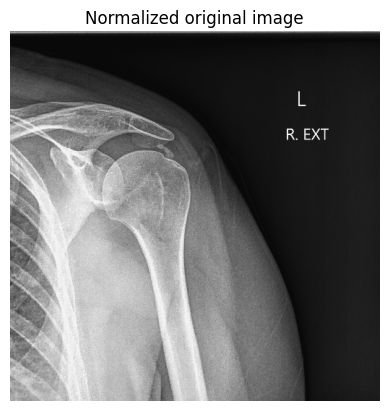

1/1 [==============================] - 1s 1s/step


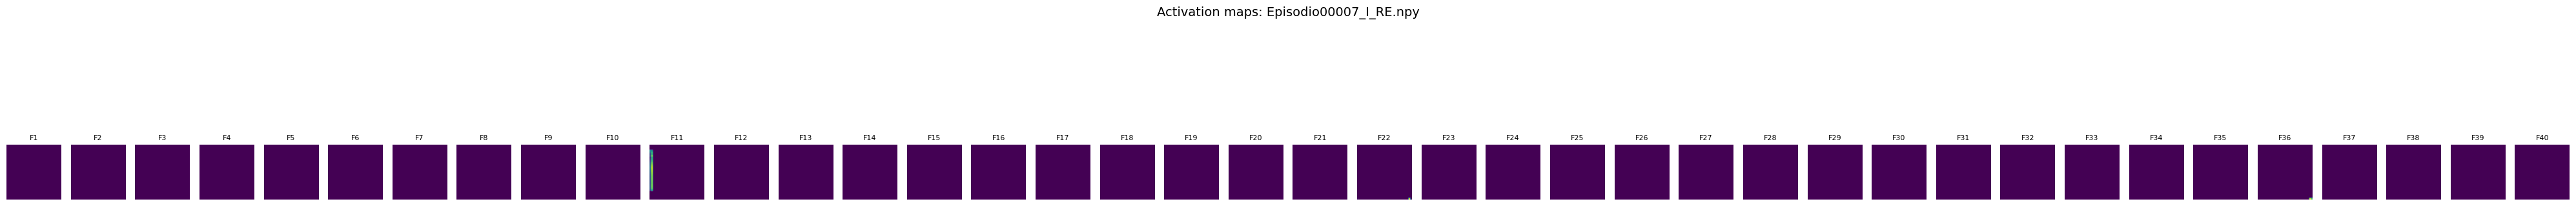

In [56]:
# Load the full model and the VGG19 subnetwork 
model_path = (
    'Models/best_cnn_model'
)
model = load_model(model_path)
conv_model = model.get_layer('vgg19')  
last_conv_layer = conv_model.get_layer('block5_conv4')
feature_extractor_viz = Model(inputs=conv_model.input, outputs=last_conv_layer.output)

# Load .npy image
img_path = "Databases/First_database/X_rays_first_database/Episodio00007_I_RE.npy"
original_image = np.load(img_path)

# Show normalized original image
norm_image = original_image.astype("float32")
norm_image -= norm_image.min()
if norm_image.max() > 0:
    norm_image /= norm_image.max()

if norm_image.ndim == 2:
    plt.imshow(norm_image, cmap='gray')
else:
    plt.imshow(norm_image)

plt.title("Normalized original image")
plt.axis("off")
plt.show()

# Preprocess image for feature extraction
img_array = original_image
if img_array.ndim == 2:
    img_array = np.stack([img_array] * 3, axis=-1)

img_array = tf.image.resize(img_array, (512, 512)).numpy()
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.vgg19.preprocess_input(img_array)

# Extract activation maps (features)
feature_maps = feature_extractor_viz.predict(img_array)[0]

# Visualize the first N activation maps
n_features = 40
fig, axes = plt.subplots(1, n_features, figsize=(40, 5))
for i in range(n_features):
    ax = axes[i]
    ax.imshow(feature_maps[:, :, i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'F{i+1}', fontsize=8)

plt.suptitle(f'Activation maps: {os.path.basename(img_path)}', fontsize=14)
plt.tight_layout()
plt.show()


### **9. Summary and Conclusions**

In this notebook we built a complete deep feature–extraction pipeline based on the best-performing CNN. Starting from structured train and test subsets of shoulder radiographs, we loaded all .npy images together with their metadata, ensured consistency between filenames and CSV entries, and created batched data generators to handle the full dataset in memory-efficient fashion. This provided a clean and reproducible input space for both the CNN and the downstream machine-learning models.

Using the VGG19 backbone embedded in the trained CNN, we extracted high-level convolutional representations from the last block and compressed them into a single feature vector per radiograph via global max pooling. These deep features were then merged with relevant clinical and technical variables (e.g. sex, age at the time of the radiograph, acquisition station), yielding final train and test tables indexed by rx_cod. These tables constitute the input for the hybrid ML models that will be evaluated later.

Finally, we visualised selected activation maps for a representative radiograph. Overall, this notebook establishes a transparent and well-documented bridge between the original imaging data and the feature space used for the hybrid CNN + ML comparison.